<a href="https://colab.research.google.com/github/kotani/kotani_che/blob/master/ECG_MFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [101]:
from google.colab import drive

In [102]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
import torch
import pathlib

In [104]:
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from PIL import Image, ImageOps

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
pwd = pathlib.Path().resolve()
data_path =  pwd/"drive/MyDrive/ECG_MFER/rawcsvdata_brugada"
normal_path =  pwd/"drive/MyDrive/ECG_MFER/rawcsvdata_normal"

In [107]:
#Sampling,0.002,sec,Resolution,1.25,uV
#I,II,V1,V2,V3,V4,V5,V6

brugada_V2 = []
#　↑なのでまずV2のみ取り出そう
for csv in data_path.glob("*.csv"):
  np_csv = np.loadtxt(csv,skiprows=2, delimiter =",",usecols = 3)
  #plt.plot(np_csv)
  brugada_V2.append(np_csv)
  #plt.plot(np_csv)
#plt.show()

In [108]:
df_brugada = pd.DataFrame(brugada_V2)

In [109]:
df_brugada["pheno"] = 1

In [110]:
#Sampling,0.002,sec,Resolution,1.25,uV
#I,II,V1,V2,V3,V4,V5,V6

normal_V2 = []
#　↑なのでまずV2のみ取り出そう
for csv in normal_path.glob("*.csv"):
  np_csv = np.loadtxt(csv,skiprows=2, delimiter =",",usecols = 3)
  #plt.plot(np_csv)
  normal_V2.append(np_csv)
  #plt.plot(normal_V2)
#plt.show()

In [111]:
df_normal = pd.DataFrame(normal_V2)
df_normal["pheno"] = 0

In [112]:
df = pd.concat([df_brugada, df_normal])

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [115]:
X = df.drop("pheno",axis = 1)
y = df.loc[:,"pheno"]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [117]:
from torch.utils.data import TensorDataset

In [118]:
#標準化する
#X_train_std = (X_train.values - np.mean(X_train.values)) / np.std(X_train.values)

#X_train_std = torch.from_numpy(X_train_std).float()
#y_train = torch.from_numpy(y_train.values)

In [119]:
#標準化しない
X_train_std = torch.from_numpy(X_train.values).float()
y_train = torch.from_numpy(y_train.values)

In [120]:
train_ds = TensorDataset(X_train_std,y_train)

In [121]:
from torch.utils.data import DataLoader

In [122]:
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle =True)

In [123]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Softmax(dim = 1)(x)
    return x
  
input_size = X_train_std.shape[1]
hidden_size = 16
output_size =2
model = Model(input_size, hidden_size, output_size)

In [124]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [125]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
  for x_batch, y_batch in train_dl:
    pred = model(x_batch)
    print(pred)
    loss = loss_fn(pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist[epoch] += loss.item() * y_batch.size(0)
    is_correct = (torch.argmax(pred,dim = 1) == y_batch).float()
    accuracy_hist[epoch] += is_correct.sum()
  loss_hist[epoch] /= len(train_dl.dataset)
  accuracy_hist[epoch] /= len(train_dl.dataset)


ストリーミング出力は最後の 5000 行に切り捨てられました。
        [0.0556, 0.9444]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1641, 0.8359],
        [0.2588, 0.7412]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3326, 0.6674],
        [0.1532, 0.8468]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0704, 0.9296],
        [0.0435, 0.9565]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2450, 0.7550],
        [0.1372, 0.8628]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2433, 0.7567],
        [0.1322, 0.8678]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0705, 0.9295],
        [0.1930, 0.8070]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2083, 0.7917],
        [0.1537, 0.8463]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3312, 0.6688],
        [0.0395, 0.9605]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0230, 0.9770],
        [0.2848, 0.7152]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0464, 0.9536]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3915, 0.6085],
        [0.0390, 0.9610]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0378, 0.9622],
        [0.0941, 0.905

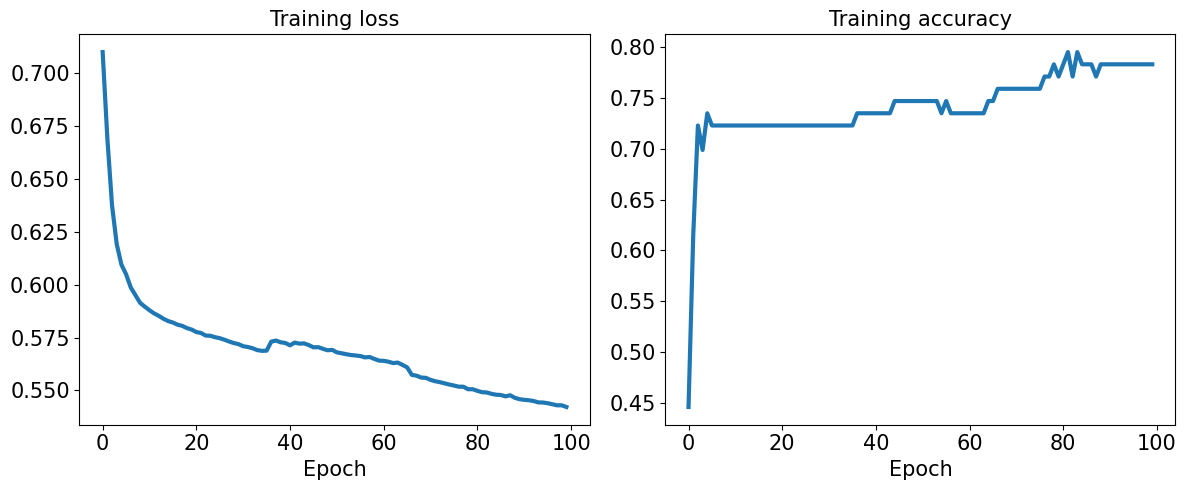

In [126]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(loss_hist, lw = 3)
ax.set_title("Training loss",size = 15)
ax.set_xlabel("Epoch", size = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(accuracy_hist, lw = 3)
ax.set_title("Training accuracy", size = 15)
ax.set_xlabel("Epoch", size = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
plt.tight_layout()

In [127]:
#標準化する
#X_test_std = (X_test.values - np.mean(X_test.values)) / np.std(X_test.values)

#X_test_std = torch.from_numpy(X_test_std).float()
#y_test = torch.from_numpy(y_test.values)
#pred_test = model(X_test_std)
#correct = (torch.argmax(pred_test, dim = 1) == y_test).float()
#accuracy = correct.mean()
#print(f"Test Acc : {accuracy:.4f}")

In [128]:
#標準化しない

X_test_std = torch.from_numpy(X_test.values).float()
y_test = torch.from_numpy(y_test.values)
pred_test = model(X_test_std)
correct = (torch.argmax(pred_test, dim = 1) == y_test).float()
accuracy = correct.mean()
print(f"Test Acc : {accuracy:.4f}")

Test Acc : 0.7619


In [141]:
g = make_dot(pred_test,params = dict(model.named_parameters()))

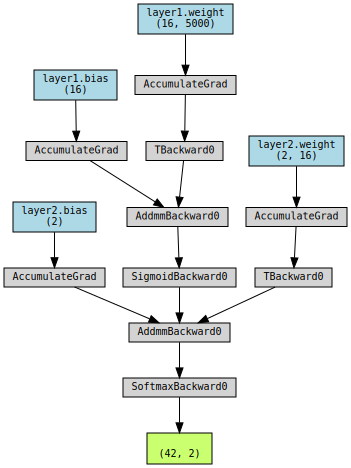

In [142]:
display(g)

In [137]:
print(model)

Model(
  (layer1): Linear(in_features=5000, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=2, bias=True)
)


In [138]:
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            80,016
├─Linear: 1-2                            34
Total params: 80,050
Trainable params: 80,050
Non-trainable params: 0